# evaluation 3

the point of this is to evaluate the models, the 6mer mamba model and the CNN embedding models

In [1]:
import evals.evals_utils_graphreg as g
ckpt_path = '/data1/lesliec/sarthak/caduceus/outputs/2024-11-29/13-42-54-267613/checkpoints/06-val_loss=-0.55113.ckpt' #the 6mer model
evals = g.Evals(ckpt_path)

base_path: /data1/lesliec/sarthak/


In [4]:
len(evals.dataset.tokenizer.complement_map) #indeed is 15625, perfect!!

15625

In [7]:
results = evals.evaluate(batch_size=16)

100%|██████████| 173/173 [32:46<00:00, 11.37s/it]


In [8]:
results.shape #should be 21165 x 1000 x 3 for train, but we obviously did test

(2756, 1000, 3)

In [9]:
import numpy as np
true = np.load('/data1/lesliec/sarthak/data/GraphReg/model_out/true_test_K562.npy')
true.shape

(2756, 1000, 3)

In [11]:
#ok so let's save out these results
np.save('/data1/lesliec/sarthak/data/GraphReg/model_out/pred_test_100k_6mer_e6_12.2.npy', results)

In [1]:
#and let's do model 2
import evals.evals_utils_graphreg as g
ckpt_path = '/data1/lesliec/sarthak/caduceus/outputs/2024-11-29/12-54-06-397365/checkpoints/16-val_loss=-0.78899.ckpt'
evals = g.Evals(ckpt_path)

base_path: /data1/lesliec/sarthak/


In [2]:
len(evals.dataset.tokenizer.complement_map) #should only be 12 as it's cnn input

12

In [3]:
evals.backbone #ahh perfect word embeddings is the double convolution!!

DNAEmbeddingModelCaduceus(
  (caduceus): Caduceus(
    (backbone): CaduceusMixerModel(
      (embeddings): CaduceusEmbeddings(
        (word_embeddings): Sequential(
          (0): Conv1d(4, 128, kernel_size=(15,), stride=(1,), padding=same)
          (1): ReLU()
          (2): Conv1d(128, 256, kernel_size=(15,), stride=(1,), padding=same)
          (3): ReLU()
          (4): Transpose()
        )
      )
      (layers): ModuleList(
        (0-15): 16 x Block(
          (mixer): BiMambaWrapper(
            (mamba_fwd): Mamba(
              (in_proj): Linear(in_features=256, out_features=1024, bias=False)
              (conv1d): Conv1d(512, 512, kernel_size=(4,), stride=(1,), padding=(3,), groups=512)
              (act): SiLU()
              (x_proj): Linear(in_features=512, out_features=48, bias=False)
              (dt_proj): Linear(in_features=16, out_features=512, bias=True)
              (out_proj): Linear(in_features=512, out_features=256, bias=False)
            )
            (m

In [4]:
#and now let's evaluate
results = evals.evaluate(batch_size=16)

100%|██████████| 173/173 [15:52<00:00,  5.51s/it]


In [5]:
results.shape

(2756, 1000, 3)

In [7]:
import numpy as np
np.save('/data1/lesliec/sarthak/data/GraphReg/model_out/pred_test_100k_cnn-embed_e16_12.2.npy', results)

# and now plot

In [8]:
from tqdm import tqdm
from scipy.stats import spearmanr
import numpy as np
true_vals = np.load('/data1/lesliec/sarthak/data/GraphReg/model_out/true_test_K562.npy')
pred_vals_6mer = np.load('/data1/lesliec/sarthak/data/GraphReg/model_out/pred_test_100k_6mer_e6_12.2.npy')
pred_vals_cnn = np.load('/data1/lesliec/sarthak/data/GraphReg/model_out/pred_test_100k_cnn-embed_e16_12.2.npy')
pred_tf = np.load('/data1/lesliec/sarthak/data/GraphReg/model_out/pred_test_tf_K562.npy')

corrs_6mer = np.zeros((true_vals.shape[0], 3))
corrs_cnn = np.zeros((true_vals.shape[0], 3))
corrs_tf = np.zeros((true_vals.shape[0], 3))

for i in tqdm(range(true_vals.shape[0])):
    for j in range(3):
        corrs_6mer[i,j] = spearmanr(true_vals[i,:,j], pred_vals_6mer[i,:,j]).correlation
        corrs_cnn[i,j] = spearmanr(true_vals[i,:,j], pred_vals_cnn[i,:,j]).correlation
        corrs_tf[i,j] = spearmanr(true_vals[i,:,j], pred_tf[i,:,j]).correlation

100%|██████████| 2756/2756 [00:07<00:00, 358.66it/s]


In [11]:
#make sure not a lot of nans
print(np.sum(np.isnan(corrs_6mer)), np.sum(np.isnan(corrs_cnn)), np.sum(np.isnan(corrs_tf)))

0 0 0


In [13]:
#print the means of these
print(np.mean(corrs_6mer, axis=0))
print(np.mean(corrs_cnn, axis=0))
print(np.mean(corrs_tf, axis=0))

[0.20246078 0.20742701 0.49666239]
[0.29236771 0.31146967 0.74328958]
[0.23293424 0.28302498 0.66176251]


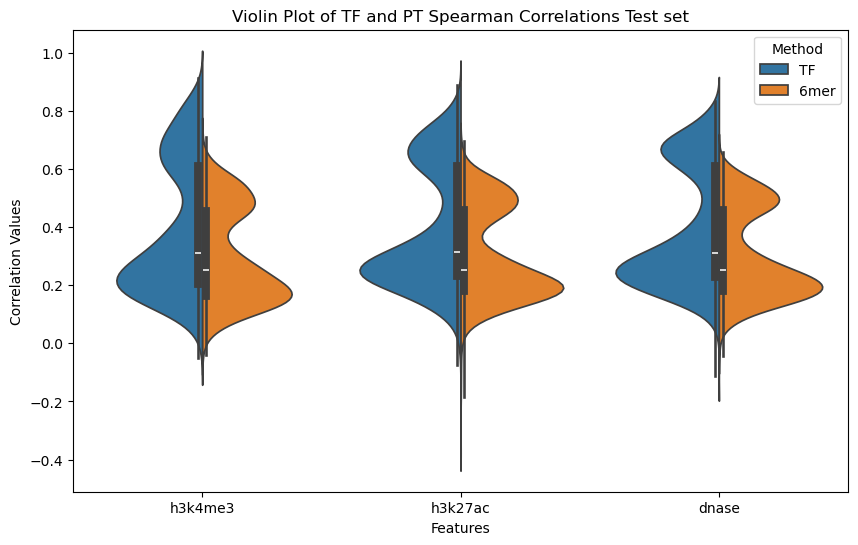

In [15]:
#ok now let's plot it
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
dataset = ['K562'] * true_vals.shape[0] #literally just so that we can use len(dataset)
data = np.concatenate([corrs_tf, corrs_6mer], axis=0)
labels = ['h3k4me3'] * len(dataset) + ['h3k27ac'] * len(dataset) + ['dnase'] * len(dataset)
methods = ['TF'] * len(dataset) + ['6mer'] * len(dataset)
labels = np.tile(labels, 2)  # Repeat labels for TF and PT
methods = np.repeat(methods, 3)  # Match order to labels

# Create a DataFrame for seaborn
df = pd.DataFrame({
    "Values": data.flatten(),
    "Feature": labels,
    "Method": methods
})

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.violinplot(x="Feature", y="Values", hue="Method", data=df, split=True)
plt.title("Violin Plot of TF and PT Spearman Correlations Test set")
plt.ylabel("Correlation Values")
plt.xlabel("Features")
plt.legend(title="Method")
plt.show()

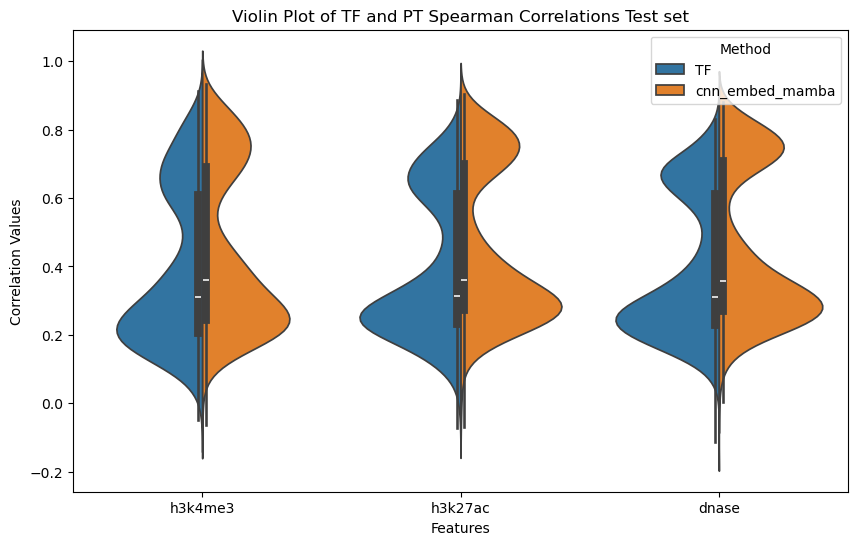

In [16]:
data = np.concatenate([corrs_tf, corrs_cnn], axis=0)
labels = ['h3k4me3'] * len(dataset) + ['h3k27ac'] * len(dataset) + ['dnase'] * len(dataset)
methods = ['TF'] * len(dataset) + ['cnn_embed_mamba'] * len(dataset)
labels = np.tile(labels, 2)  # Repeat labels for TF and PT
methods = np.repeat(methods, 3)  # Match order to labels

# Create a DataFrame for seaborn
df = pd.DataFrame({
    "Values": data.flatten(),
    "Feature": labels,
    "Method": methods
})

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.violinplot(x="Feature", y="Values", hue="Method", data=df, split=True)
plt.title("Violin Plot of TF and PT Spearman Correlations Test set")
plt.ylabel("Correlation Values")
plt.xlabel("Features")
plt.legend(title="Method")
plt.show()

In [17]:
corrs_cnn.shape

(2756, 3)

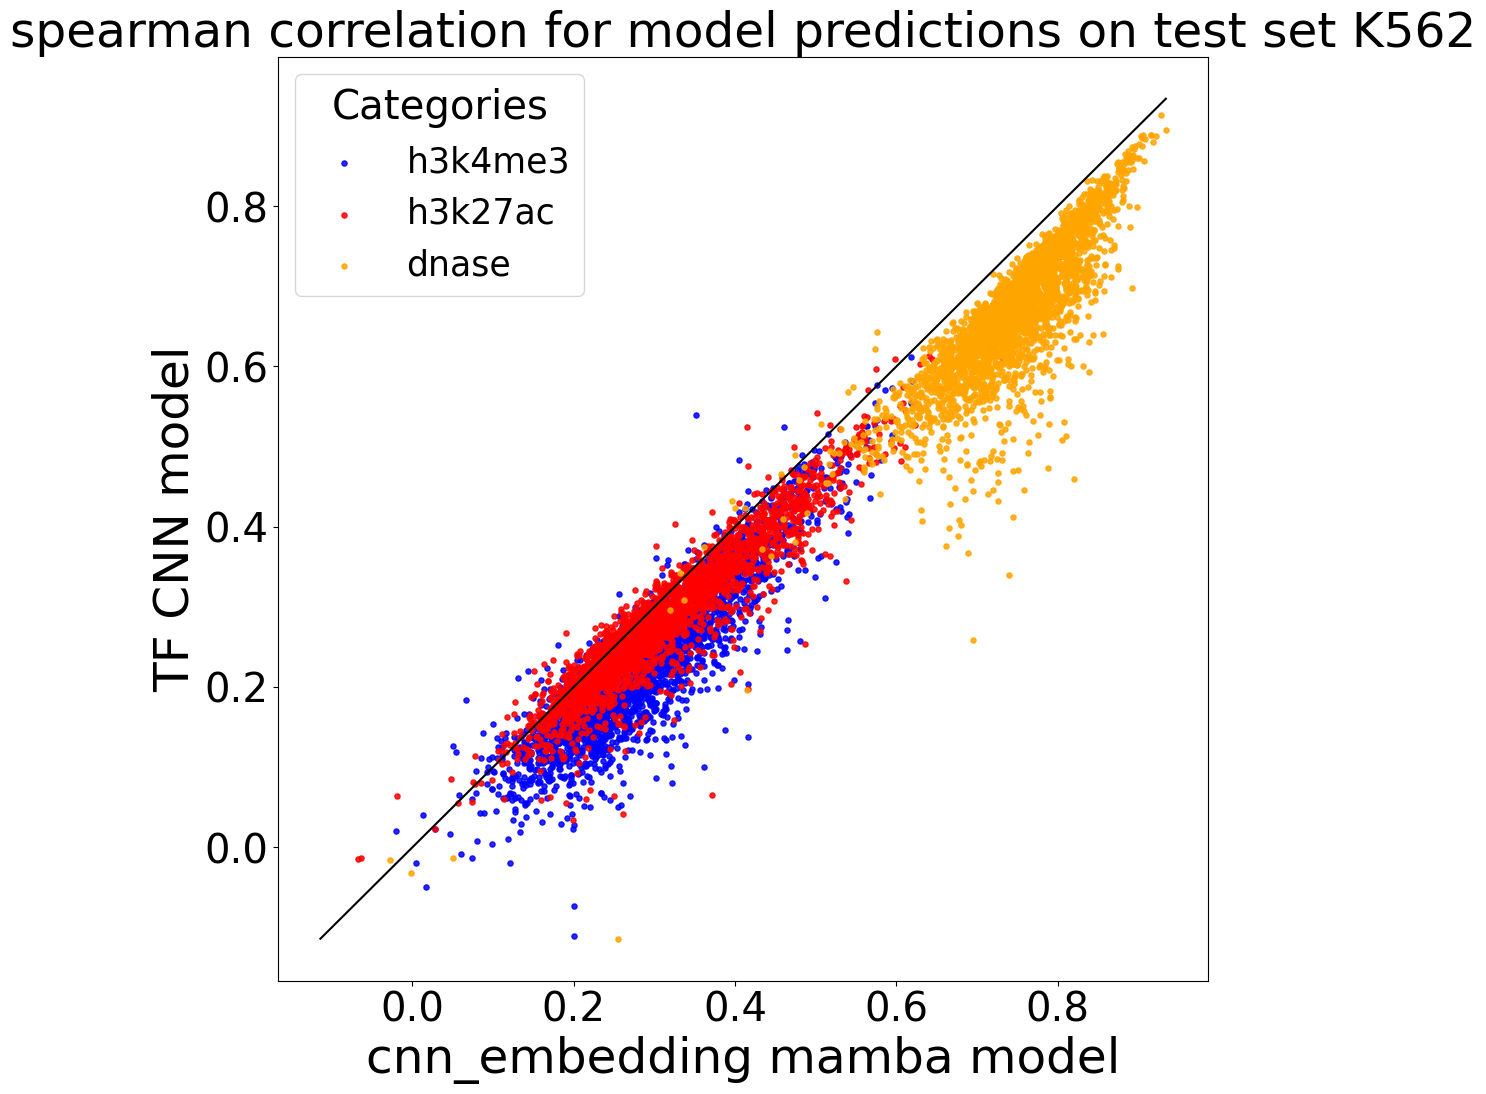

In [21]:
#let's now do our scatter plot

x,y = corrs_cnn, corrs_tf


z2 = np.array([0, 1, 2])  # Categories for columns: 0 = CHIP, 1 = DNase, 2 = ATAC

# Define the colors for each category
colors = ['blue', 'red', 'orange']

# Create a scatter plot for each column with different colors
plt.figure(figsize=(12, 12))
for i, color in enumerate(colors):
    plt.scatter(x[:, i], y[:, i], color=color, label=['h3k4me3', 'h3k27ac', 'dnase'][i], s=55, marker='.', alpha=0.85)

# Compute plot limits
tempmin = min(np.min(x), np.min(y))
tempmax = max(np.max(x), np.max(y))

# Add a reference line
plt.plot([tempmin, tempmax], [tempmin, tempmax], c='k')  

# Add labels, title, and legend
plt.xlabel('cnn_embedding mamba model', fontsize=35)
plt.ylabel('TF CNN model', fontsize=35)
plt.title('spearman correlation for model predictions on test set K562', fontsize=35)
plt.tick_params(labelsize=29)
plt.legend(title="Categories", fontsize=25, title_fontsize=29)

In [22]:
#testing the output of the models quickly
a,b = evals.dataset[0]
a.shape, b.shape

(torch.Size([4, 100000]), torch.Size([1000, 3]))

In [25]:
out = evals.backbone(a.unsqueeze(0).to('cuda'))

In [27]:
out[0].shape

torch.Size([1, 100000, 256])

In [33]:
evals.backbone.caduceus.backbone.embeddings.word_embeddings(a.unsqueeze(0).to('cuda')).shape

torch.Size([1, 100000, 256])

In [34]:
evals.decoder

GraphRegDecoder(
  (pool): AvgPool1d(kernel_size=(100,), stride=(100,), padding=(0,))
  (output_transform): Linear(in_features=256, out_features=3, bias=True)
)

# fixing the plots

In [1]:
from tqdm import tqdm
from scipy.stats import spearmanr
import numpy as np
true_vals = np.load('/data1/lesliec/sarthak/data/GraphReg/model_out/true_test_K562.npy')
pred_vals_6mer = np.load('/data1/lesliec/sarthak/data/GraphReg/model_out/pred_test_100k_6mer_e6_12.2.npy')
pred_vals_cnn = np.load('/data1/lesliec/sarthak/data/GraphReg/model_out/pred_test_100k_cnn-embed_e16_12.2.npy')
pred_tf = np.load('/data1/lesliec/sarthak/data/GraphReg/model_out/pred_test_tf_K562.npy')

corrs_6mer = np.zeros((true_vals.shape[0], 3))
corrs_cnn = np.zeros((true_vals.shape[0], 3))
corrs_tf = np.zeros((true_vals.shape[0], 3))

for i in tqdm(range(true_vals.shape[0])):
    for j in range(3):
        corrs_6mer[i,j] = spearmanr(true_vals[i,:,j], pred_vals_6mer[i,:,j]).correlation
        corrs_cnn[i,j] = spearmanr(true_vals[i,:,j], pred_vals_cnn[i,:,j]).correlation
        corrs_tf[i,j] = spearmanr(true_vals[i,:,j], pred_tf[i,:,j]).correlation

100%|██████████| 2756/2756 [00:08<00:00, 344.46it/s]


In [8]:
true_vals.shape

(2756, 1000, 3)

In [2]:
#make sure not a lot of nans
print(np.sum(np.isnan(corrs_6mer)), np.sum(np.isnan(corrs_cnn)), np.sum(np.isnan(corrs_tf)))

0 0 0


In [3]:
#print the means of these
print(np.mean(corrs_6mer, axis=0))
print(np.mean(corrs_cnn, axis=0))
print(np.mean(corrs_tf, axis=0))

[0.20246078 0.20742701 0.49666239]
[0.29236771 0.31146967 0.74328958]
[0.23293424 0.28302498 0.66176251]


In [4]:
#ok now let's plot it
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
dataset = ['K562'] * true_vals.shape[0] #literally just so that we can use len(dataset)
data = np.concatenate([corrs_tf, corrs_6mer], axis=0)
labels = ['h3k4me3'] * len(dataset) + ['h3k27ac'] * len(dataset) + ['dnase'] * len(dataset)
methods = ['TF'] * len(dataset) + ['6mer'] * len(dataset)
labels = np.tile(labels, 2)  # Repeat labels for TF and PT
methods = np.repeat(methods, 3)  # Match order to labels

# Create a DataFrame for seaborn
df = pd.DataFrame({
    "Values": data.flatten(),
    "Feature": labels,
    "Method": methods
})

df.head()

# Plot using seaborn
# plt.figure(figsize=(10, 6))
# sns.violinplot(x="Feature", y="Values", hue="Method", data=df, split=True)
# plt.title("Violin Plot of TF and PT Spearman Correlations Test set")
# plt.ylabel("Correlation Values")
# plt.xlabel("Features")
# plt.legend(title="Method")
# plt.show()

,Values,Feature,Method
0,0.524977,h3k4me3,TF
1,0.060010,h3k4me3,TF
2,0.363420,h3k4me3,TF
3,0.049976,h3k4me3,TF
4,0.171182,h3k4me3,TF


In [6]:
#so let's look at this df and make sure it's correct... because what is below shouldn't be correct?
corrs_tf.shape

(2756, 3)

In [7]:
#we definitely have some minor error...
df

,Values,Feature,Method
0,0.524977,h3k4me3,TF
1,0.060010,h3k4me3,TF
2,0.363420,h3k4me3,TF
3,0.049976,h3k4me3,TF
4,0.171182,h3k4me3,TF
...,...,...,...
16531,0.347094,dnase,6mer
16532,0.481004,dnase,6mer
16533,0.166856,dnase,6mer
16534,0.109575,dnase,6mer


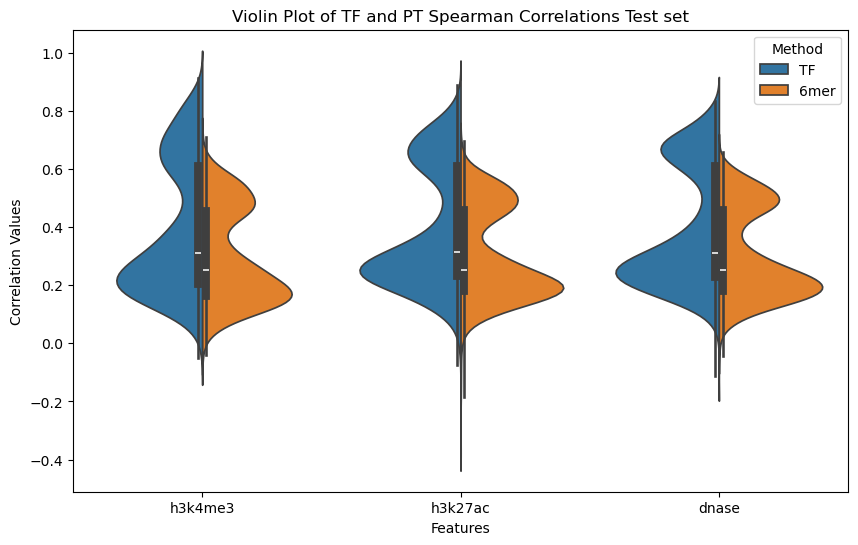

In [5]:
plt.figure(figsize=(10, 6))
sns.violinplot(x="Feature", y="Values", hue="Method", data=df, split=True)
plt.title("Violin Plot of TF and PT Spearman Correlations Test set")
plt.ylabel("Correlation Values")
plt.xlabel("Features")
plt.legend(title="Method")
plt.show()

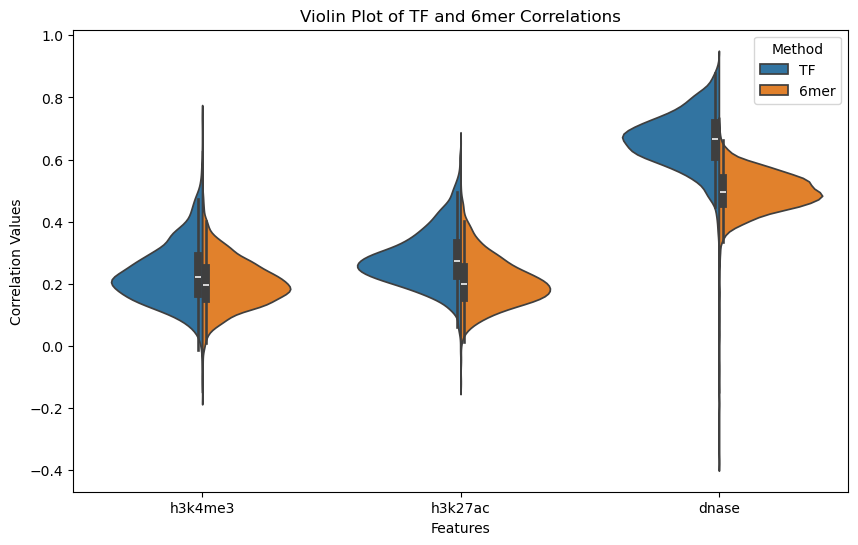

In [9]:
df = pd.DataFrame({
    "TF1": corrs_tf[:, 0],
    "TF2": corrs_tf[:, 1],
    "TF3": corrs_tf[:, 2],
    "6mer1": corrs_6mer[:, 0],
    "6mer2": corrs_6mer[:, 1],
    "6mer3": corrs_6mer[:, 2]
})

df_melted = df.melt(var_name="Feature_Method", value_name="Values")

# Split "Feature_Method" into "Feature" and "Method" columns
df_melted["Feature"] = df_melted["Feature_Method"].str.extract(r'(TF|6mer)(\d)')[1].map({"1": "h3k4me3", "2": "h3k27ac", "3": "dnase"})
df_melted["Method"] = df_melted["Feature_Method"].str.extract(r'(TF|6mer)')[0]

# Plot the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x="Feature", y="Values", hue="Method", data=df_melted, split=True)
plt.title("Violin Plot of TF and 6mer Correlations")
plt.ylabel("Correlation Values")
plt.xlabel("Features")
plt.legend(title="Method")
plt.show()

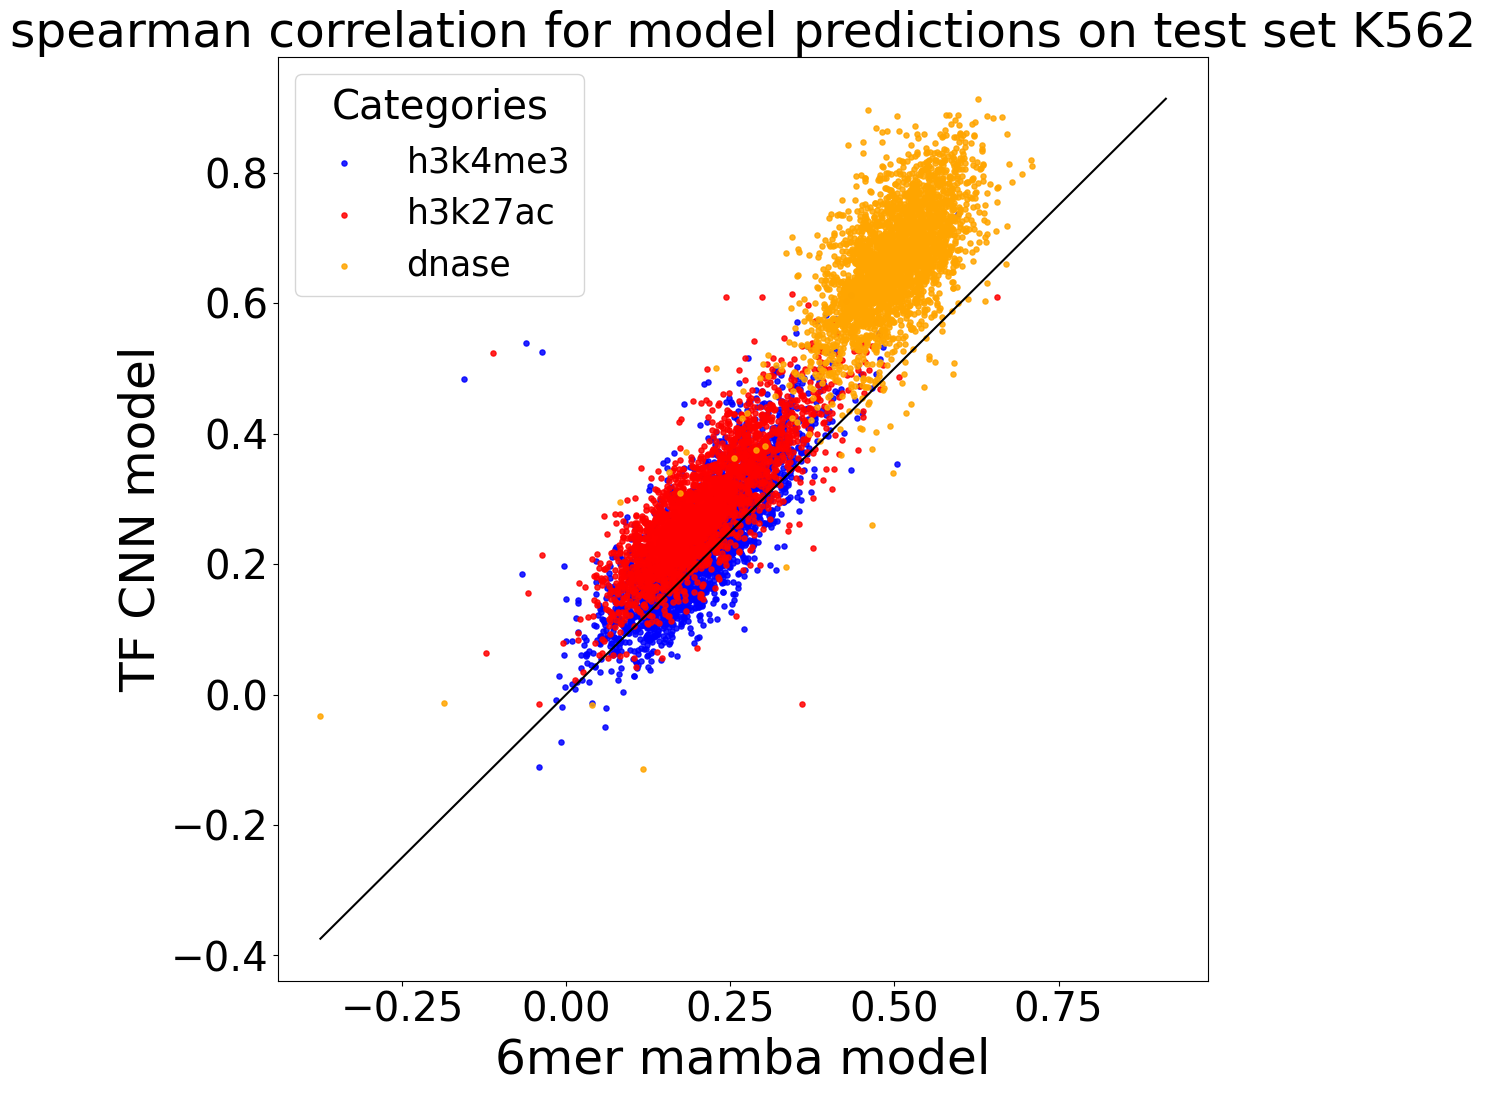

In [10]:
#that's better, and let's look at this one too
x,y = corrs_6mer, corrs_tf


z2 = np.array([0, 1, 2])  # Categories for columns: 0 = CHIP, 1 = DNase, 2 = ATAC

# Define the colors for each category
colors = ['blue', 'red', 'orange']

# Create a scatter plot for each column with different colors
plt.figure(figsize=(12, 12))
for i, color in enumerate(colors):
    plt.scatter(x[:, i], y[:, i], color=color, label=['h3k4me3', 'h3k27ac', 'dnase'][i], s=55, marker='.', alpha=0.85)

# Compute plot limits
tempmin = min(np.min(x), np.min(y))
tempmax = max(np.max(x), np.max(y))

# Add a reference line
plt.plot([tempmin, tempmax], [tempmin, tempmax], c='k')  

# Add labels, title, and legend
plt.xlabel('6mer mamba model', fontsize=35)
plt.ylabel('TF CNN model', fontsize=35)
plt.title('spearman correlation for model predictions on test set K562', fontsize=35)
plt.tick_params(labelsize=29)
plt.legend(title="Categories", fontsize=25, title_fontsize=29)

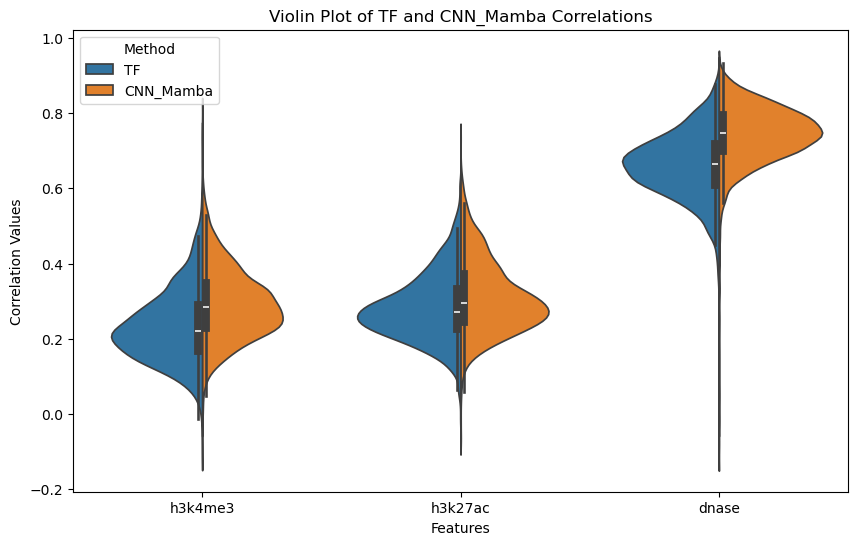

In [16]:
# data = np.concatenate([corrs_tf, corrs_cnn], axis=0)
# labels = ['h3k4me3'] * len(dataset) + ['h3k27ac'] * len(dataset) + ['dnase'] * len(dataset)
# methods = ['TF'] * len(dataset) + ['cnn_embed_mamba'] * len(dataset)
# labels = np.tile(labels, 2)  # Repeat labels for TF and PT
# methods = np.repeat(methods, 3)  # Match order to labels

# Create a DataFrame for seaborn
corr1 = corrs_tf
corr2 = corrs_cnn
corr1_label = "TF"  # Label for corr1
corr2_label = "CNN_Mamba"  # Label for corr2

# Construct DataFrame
df = pd.DataFrame({
    f"{corr1_label}1": corr1[:, 0],
    f"{corr1_label}2": corr1[:, 1],
    f"{corr1_label}3": corr1[:, 2],
    f"{corr2_label}1": corr2[:, 0],
    f"{corr2_label}2": corr2[:, 1],
    f"{corr2_label}3": corr2[:, 2]
})

# Melt the dataframe to long format for plotting
df_melted = df.melt(var_name="Feature_Method", value_name="Values")

# Split "Feature_Method" into "Feature" and "Method" columns
df_melted["Feature"] = df_melted["Feature_Method"].str.extract(rf'({corr1_label}|{corr2_label})(\d)')[1].map({"1": "h3k4me3", "2": "h3k27ac", "3": "dnase"})
df_melted["Method"] = df_melted["Feature_Method"].str.extract(rf'({corr1_label}|{corr2_label})')[0]

# Plot the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x="Feature", y="Values", hue="Method", data=df_melted, split=True)
plt.title(f"Violin Plot of {corr1_label} and {corr2_label} Correlations")
plt.ylabel("Correlation Values")
plt.xlabel("Features")
plt.legend(title="Method")
plt.show()